# COGS 108 Final Project

## Group Members: 
- A13382470

### Introduction and Background:



Which components of a kickstarter are most important for a fundraiser to reach its goal? How do factors such as date started, duration, money goal, and category of a kickstarter , comparatively, influence fundraiser success? Answering these questions can guide those who are looking to create their own kickstarter and start a successful business. There have been previous projects in this area studying what separates successful kickstarters from failed ones. We take a different approach and analyze how these factors rank against each other.  

Our initial hypothesis is that kickstarter category will be the most important factor in kickstarter success, due to some categories being inherently more popular and appealing than others. Categories such as “Design and Tech” category will likely be more successful due to the popularity surrounding technology-driven products.


### Data Description:


Dataset Name: Kickstarter Datasets (Web Robots)

Link to the dataset: https://webrobots.io/kickstarter-datasets/

Number of observations: 207k

The dataset is a large (200k+) collection of data about different Kickstarters, including whether they succeed in reaching their goal. Other information pertaining to the kickstarter range from the name and category of the kickstarter to how much it is asking for or how long the fundraising period was.

The information includes: ID, internal kickstarter id, name, name of project, category, main_category, category of campaign, currency used to support, deadline for crowdfunding, fundraising goal, date launched, amount pledged by "crowd", current condition the project is in.


### Starting out: imports

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
import operator

from datetime import datetime, timedelta

### Data Cleaning and Pre-processing

Here we load the JSON file and select the columns that we want from the web-scraper's data. We also have to apply a function to parse the category name as it is separated by a forward slash 

In [2]:
with open('Kickstarter_2018-12-13T03_20_05_701Z.json') as f:
    
    data = []
    
    # Iterate through each line in file which is a JSON object
    for line in f:
        
        # Load object
        obj = json.loads(line)
 
        # Choose columns
        item = []
        item.append(obj['data']['id'])
        item.append(obj['data']['name'])
        item.append(obj['data']['blurb'])
        item.append(obj['data']['goal'])
        item.append(obj['data']['pledged'])
        item.append(obj['data']['state'])
        item.append(obj['data']['country'])
        item.append(obj['data']['deadline'])
        item.append(obj['data']['created_at'])
        item.append(obj['data']['launched_at'])
        item.append(obj['data']['backers_count'])
        item.append(obj['data']['usd_pledged'])
        item.append(obj['data']['category']['slug'])
        item.append(obj['data']['category']['name'])
        data.append(item)
        
# Fix columns list if adding/removing columns
columns = ['id', 'name', 'blurb', 'goal', 'pledged', 'state', 'country', 'deadline', 'created_at', 'launched_at', 'backers_count', 'usd_pledged', 'category', 'subcategory']
df = pd.DataFrame(data, columns=columns)

def getCategory(name):
    return name.split('/')[0]

# Fix category
df['category'] = df['category'].apply(getCategory)
df.head()

,id,name,blurb,goal,pledged,state,country,deadline,created_at,launched_at,backers_count,usd_pledged,category,subcategory
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,25000.0,27455.55,successful,US,1353256229,1339525842,1350660629,170,27455.55,film & video,Documentary
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,500.0,535.00,successful,US,1355949544,1351941026,1353357544,10,535.0,publishing,Children's Books
2,1745190062,DC Radio,We are college students that get drunk and the...,3500.0,0.00,failed,CA,1418916011,1415917256,1416324011,0,0.0,journalism,Audio
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",20000.0,0.00,failed,US,1449345000,1446664703,1446672167,0,0.0,music,World Music
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,5000.0,6705.00,successful,US,1287200340,1284003536,1284042614,62,6705.0,film & video,Documentary


Next, we notice that the deadline, created_at, and launched_at values look odd. Turns out they are in unix time, we we will transform them to be more readable.

In [3]:
deadline_str = []
duration_str = []
launch_date = []
deadline_int = []

for i, row in df.iterrows():

    unix_ts = int(row['deadline'])
    dt = (datetime.fromtimestamp(unix_ts) - timedelta(hours=2)).strftime('%Y-%m-%d %H:%M:%S')
    deadline_str.append(dt)
    
    launch_date_ts = int(row['launched_at'])
    launch_dt = (datetime.fromtimestamp(launch_date_ts) - timedelta(hours=2)).strftime('%Y-%m-%d %H:%M:%S')
    launch_date.append(launch_dt)
    
    duration_unix_ts = unix_ts - launch_date_ts
    duration_days = (duration_unix_ts / (60*60*24))
    duration_str.append(duration_days)
    
df['launched_at_str'] = launch_date
df['deadline_str'] = deadline_str
df['duration_days'] = duration_str

for i, row in df.iterrows():
    
    dt = row['deadline_str']
    dt2 = dt.split(' ')[0].split('-')[1]+dt.split(' ')[0].split('-')[2]+dt.split(' ')[0].split('-')[0]
    deadline_int.append(dt2)

df['deadline_int'] = deadline_int

# Drop columns we don't need anymore
df.drop(labels=['deadline', 'created_at', 'launched_at'], axis=1, inplace=True)
    
# Check df
df.head()

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,25000.0,27455.55,successful,US,170,27455.55,film & video,Documentary,2012-10-19 06:30:29,2012-11-18 06:30:29,30.041667,11182012
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,500.0,535.00,successful,US,10,535.0,publishing,Children's Books,2012-11-19 10:39:04,2012-12-19 10:39:04,30.000000,12192012
2,1745190062,DC Radio,We are college students that get drunk and the...,3500.0,0.00,failed,CA,0,0.0,journalism,Audio,2014-11-18 05:20:11,2014-12-18 05:20:11,30.000000,12182014
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",20000.0,0.00,failed,US,0,0.0,music,World Music,2015-11-04 11:22:47,2015-12-05 09:50:00,30.935567,12052015
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,5000.0,6705.00,successful,US,62,6705.0,film & video,Documentary,2010-09-09 05:30:14,2010-10-15 18:39:00,36.547755,10152010


Check for any null values in our DataFrame

In [4]:
df.loc[df.isnull().any(axis=1)==True,:]

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int


As we can see above there are no rows with null values, so we don't have to worry about dealing with null values.

### Data Visualization

Let's start by looking at how different categories and subcategories rank against each other:

In [50]:
# Code for successful kickstarters in 'category'
item = df['category'].unique()
out = {}
counts = df['category'].value_counts().tolist()
for val in item:
    temp = df[(df['category']== val) & (df['state']=='successful')]['id'].size
    out[val] = temp
    
# Code for successful kickstarters in 'subcategory'
item2 = df['subcategory'].unique()
out2 = {}
counts2 = df['subcategory'].value_counts().tolist()
dfTest = pd.DataFrame(item2, columns=['subcategory'])
searchFor = ['Literary Spaces', 'Letterpress', 'Chiptune', 'Taxidermy']
dfTest = dfTest[~dfTest['subcategory'].isin(searchFor)]
item2 = dfTest['subcategory'].unique()
for val in item2:
    temp2 = df[(df['subcategory']== val) & (df['state']=='successful')]['id'].size
    out2[val] = temp2
    
# Code to get success rate for 'category'
dict1 = df['category'].value_counts().to_dict() # total vals
dict2 = out # successful (out)
dict3 = {} # success rate
for cat in item:
    total = dict1[cat]
    success = dict2[cat]
    dict3[cat] = success/total
testList = list(dict3.values())
testList2 = np.sort(testList)
testList3 = testList2[::-1]
sorted_x = sorted(dict3.items(), key=operator.itemgetter(1), reverse=True)

# Code to get success rate for 'subcategory'
dict4 = df['subcategory'].value_counts().to_dict() # total vals
dict5 = out2 # successful (out)
dict6 = {} # success rate
for cat in item2:
    total2 = dict4[cat]
    success2 = dict5[cat]
    dict6[cat] = success2/total2
testList4 = list(dict6.values())
testList5 = np.sort(testList4)
testList6 = testList5[::-1]
sorted_x2 = sorted(dict6.items(), key=operator.itemgetter(1), reverse=True)

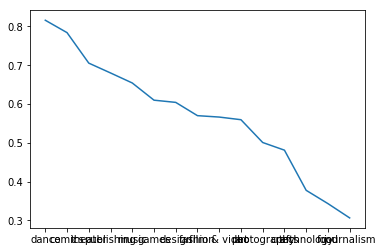

Web                  4329
Product Design       4149
Tabletop Games       3643
Shorts               3206
Documentary          3113
Hardware             3056
Video Games          3043
Fiction              2902
Nonfiction           2900
Indie Rock           2855
Comedy               2772
Public Art           2728
Children's Books     2725
Rock                 2700
Apparel              2665
Painting             2659
Country & Folk       2655
Art Books            2643
Mixed Media          2620
Software             2613
Narrative Film       2600
Comic Books          2585
Accessories          2570
Pop                  2566
Apps                 2556
Illustration         2555
Performance Art      2552
Gadgets              2550
Mobile Games         2540
Webseries            2523
                     ... 
Animals               324
Couture               319
Community Gardens     319
Kids                  318
Knitting              318
Blues                 312
Fabrication Tools     304
Photo       

In [55]:
x, y = zip(*sorted_x)
plt.plot(x,y)
plt.show()
df['subcategory'].value_counts()

In [9]:
print("Here is the success rate for the categories:")
print(sorted_x)
print("Here is the success rate for the categories:")
print(sorted_x2)

Here is the success rate for the categories:
[('dance', 0.8158745956705649), ('comics', 0.7839293901879871), ('theater', 0.7053268407850081), ('publishing', 0.6799820242672392), ('music', 0.6541375505700625), ('games', 0.6097665759702133), ('design', 0.6040672574414906), ('fashion', 0.5698455339153794), ('film & video', 0.5662278149549025), ('art', 0.559406667645763), ('photography', 0.5006256256256256), ('crafts', 0.48088048539579514), ('technology', 0.37732704851687854), ('food', 0.34308841843088417), ('journalism', 0.3061792863359443)]
Here is the success rate for the categories:
[('Theater', 0.9974293059125964), ('Dance', 0.9961513790891597), ('Photography', 0.992953611274222), ('Comics', 0.9918533604887984), ('Indie Rock', 0.989492119089317), ('Country & Folk', 0.9804143126177024), ('Fashion', 0.9796495195025439), ('Rock', 0.9792592592592593), ('Food', 0.9752973467520586), ('Shorts', 0.9737991266375546), ('Fiction', 0.968986905582357), ('Crafts', 0.966412213740458), ('Nonfiction',

Next, we will examine how using certain words to describe a Kickstarter project may have an effect on the success.

In [10]:
# Get rid of kickstarters that are live or failed
df_successful = df.loc[df['state']=='successful',:]

In [22]:
# Create a dictionary of words with their counts
words = {}
for sentence in df_successful['blurb']:
    for word in sentence.split(' '):
        word = word.lower()
        word = word.strip()
        word = word.replace('.', '')
        word = word.replace("\"", '')
        word = word.replace(',', '')
        word = word.replace(';', '')
        word = word.replace('!', '')
        word = word.replace('?', '')
        word = word.replace('\n', '')
        
        if len(word) == 0:
            continue
        elif word not in words:
            words[word] = 1
        else:
            words[word] += 1

df_words = pd.DataFrame.from_dict(words, orient='index', columns=['count'])

In [23]:
# Drop stop words
common = ['a','able','about','across','after','all','almost','also','am','among','an','and','any','are',
          'as','at','be','because','been','but','by','can','cannot','could','dear','did','do','does',
          'either','else','ever','every','for','from','get','got','had','has','have','he','her','hers',
          'him','his','how','however','i','if','in','into','is','it','its','just','least','let','like',
          'likely','may','me','might','most','must','my','neither','no','nor','not','of','off','often',
          'on','only','or','other','our','own','rather','said','say','says','she','should','since','so',
          'some','than','that','the','their','them','then','there','these','they','this','tis','to','too',
          'twas','us','wants','was','we','were','what','when','where','which','while','who','whom','why',
          'will','with','would','yet','you','your', '-', '&', "i'm", "it's"]

df_words.drop(common, inplace=True)
df_words.head(n=20)

,count
documentary,1392
two,2986
circuses,3
remote,163
corners,36
canadian,111
arctic,82
west,551
africa,173
turning,174


We have removed the stop words but there are also words that appear very few times such as 'circuses' which only appears 3 times. There no point in looking at words with such low counts so we will filter words that fall below a certain threshold. 

In [24]:
# Get rid of words with low frequency
df_words = df_words.loc[df_words['count']>2072,:]
df_words.sort_values(by=['count'], ascending=False, inplace=True)

# Fix indexing and make column for word
df_words.reset_index(inplace=True)
df_words.columns = ['word', 'count']
df_words.head(n=20)

,word,count
0,help,14215
1,new,12969
2,book,7550
3,first,6902
4,album,6635
5,art,6405
6,music,5826
7,world,5647
8,make,5205
9,film,5117


Now that we have the words and their counts, we can plot to see how common certain words in successful projects are

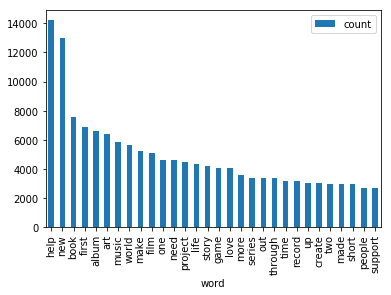

In [27]:
df_words[0:30].plot(x='word', kind='bar')

### Data Analysis and Results##

### Privacy and Ethics Considerations

For our research question, we chose to look at what makes a kickstarter project successful.  This data was collected on a website whose owners got the data by webscrapping kickstarter.  The only potential privacy issue would be that the users of kickstarter did not give us direct consent to analyze their data.  However, because kickstarter is a public forum, in order to use the site, users do have to acknowledge that the data will note be private. 

Additionally, we aren’t using the data to create revenue and instead using it for an academic purpose. Thus, it’s unlikely there will be issues related to privacy. Furthermore, our data does not violate the safe harbor laws as no names, addresses or other identifying information is included within the dataset.


### Conclusions and Discussion:



Work in progress.